## 4. 近傍法による異常検知
### 4.1 k近傍法：経験分布に基づく異常判定
#### ラベルなしデータに対するk近傍法
$M$次元ベクトル$\boldsymbol{x}$が$N$個観測されているとする。
$$
D=\{\boldsymbol{x}^{(1)},\boldsymbol{x}^{(2)},\cdots,\boldsymbol{x}^{(N)}\}
$$
このデータの経験分布は、
$$
p_{emp}(\boldsymbol{x}|D)=\frac{1}{N}\sum_{n=1}^N\delta(\boldsymbol{x}-\boldsymbol{x}^{(n)})
$$
ここで、$\delta()$はディラックのデルタ関数である。  
経験分布という用語は、$D$の中で経験された値のところでのみ値を持ち、その他の点では0になるという事実に由来する。  
ここで、任意の位置$\boldsymbol{x}'$での確率密度$p(\boldsymbol{x}')$を経験分布から求めることを考える。  

$\boldsymbol{x}'$を中心とした十分小さい半径$\epsilon$の球を考え、この中で確率密度が一定だとみなす。  
確率密度関数の定義から、
$$
p(\boldsymbol{x}')×|V_M(\epsilon,\boldsymbol{x}')|\approx\int_{\boldsymbol{x}\in V_M(\epsilon,\boldsymbol{x}')}d\boldsymbol{x}p_{emp}(\boldsymbol{x}|D)
$$
が成り立つ。この式は$(確率密度)×(体積)\approx (確率)$を意味する。  
    $\boldsymbol{x}'$を中心とした半径$\epsilon$の$M$次元旧内部の領域を$V_M(\epsilon,\boldsymbol{x}')$、その体積は$|V_M(\epsilon,\boldsymbol{x}')|$と表している。  
デルタ関数を使って右辺の積分を実行すると、
$$
p(\boldsymbol{x}')\approx\frac{k}{N|V_M(\epsilon,\boldsymbol{x}')|}
$$
となる。  
$k$は領域$V_M(\epsilon,\boldsymbol{x}')$に含まれる$D$の要素の数である。  
$M$次元空間における球の体積$V_M(\epsilon,\boldsymbol{x}')$は、半径$\epsilon$の$M$乗に比例するから異常度は、
$$
a(\boldsymbol{x}')=-\ln{p(\boldsymbol{x}'})=-\ln{k}+M\ln{\epsilon}+(定数)
$$
となる。  
$\epsilon$を固定すれば$k$が小さい方が高い異常度を与え、$k$を固定すれば$\epsilon$が大きい方が高い異常度を与える。  
  
近傍標本数$k$を定数として与えて異常判定を行う方法を**k近傍法**もしくは**k最近傍法**と呼ぶ。  
逆に、近傍半径$\epsilon$を定数として与えるやり方を**$\epsilon$近傍法**と呼ぶ。

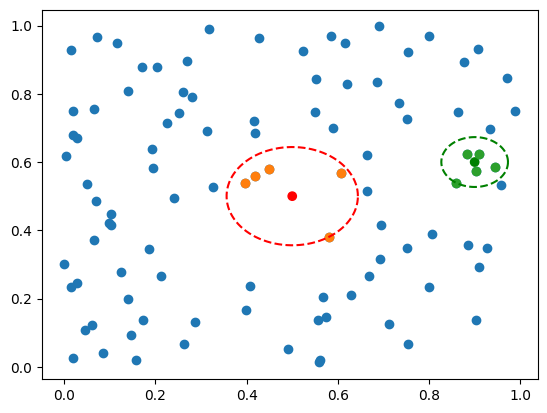

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def make_circle(x, y, r, theta):
    """円の描画用
    """
    return np.concatenate([[x + r * np.cos(theta)], [y + r * np.sin(theta)]], axis=0).T

def find_near_k(x1, x2, k):
    """k近傍点の座標と距離
    """
    dist = np.sqrt(np.sum((x1- x2.reshape(len(x2),1,2))**2, axis=2))
    neark = np.array([x1[np.argsort(dist[i])[:k],:] for i in range(len(x2))])
    eps = np.array([np.max(dist.T[np.argsort(dist[i])[:k],i]) for i in range(len(x2))])
    return neark, eps

def find_near_eps(x1, x2, eps):
    """epsilon近傍点の数(k)
    """
    dist = np.sqrt(np.sum((x1- x2.reshape(len(x2),1,2))**2, axis=2))
    k = np.sum(dist<eps, axis=1)
    return k

# 訓練用データ
N = 100
x1 = np.random.rand(N, 2)

# テストデータ
x2 = np.array([[0.5, 0.5],
               [0.9, 0.6]])

# 各点の近傍点情報を取得
neark, epsk = find_near_k(x1, x2=x2, k=5)
near_eps = find_near_eps(x1, x2, eps=0.1)

# 描画用
theta = np.linspace(0, 2*np.pi, N)

plt.scatter(x1[:,0], x1[:,1]);
plt.scatter(x2[:,0], x2[:,1], color=['red', 'green']);

c1 = make_circle(x2[0,0], x2[0,1], r=epsk[0], theta=theta)
c2 = make_circle(x2[1,0], x2[1,1], r=epsk[1], theta=theta)

plt.scatter(neark[0,:,0], neark[0,:,1]);
plt.scatter(neark[1,:,0], neark[1,:,1]);

plt.plot(c1[:,0], c1[:,1], '--', color='red');
plt.plot(c2[:,0], c2[:,1], '--', color='green');

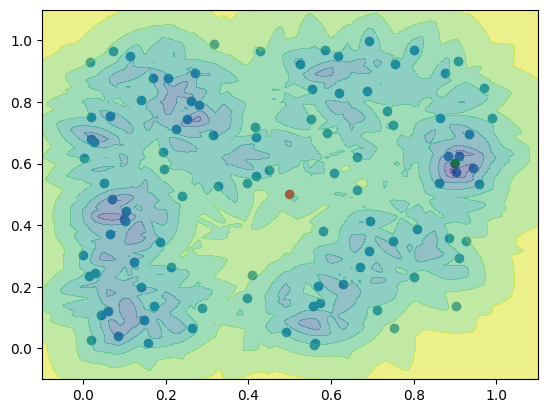

In [2]:
def knn_anomaly(k,N,eps):
    return -np.log1p(k/(N*4/3*np.pi*eps**3))

x = np.arange(-0.1,1.1,0.01)
y = np.arange(-0.1,1.1,0.01)
xx, yy = np.meshgrid(x, y)

XY = np.array([xx.ravel(), yy.ravel()]).T

# 近傍点の情報を計算
neark, epsk = find_near_k(x1, x2=XY, k=5)
near_k = find_near_eps(x1, XY, eps=0.1)

# k近傍法
plt.scatter(x1[:,0], x1[:,1]);
plt.scatter(x2[:,0], x2[:,1], color=['red', 'green']);

plt.contourf(xx,yy,knn_anomaly(5, N, epsk).reshape(121,121), alpha=.5)

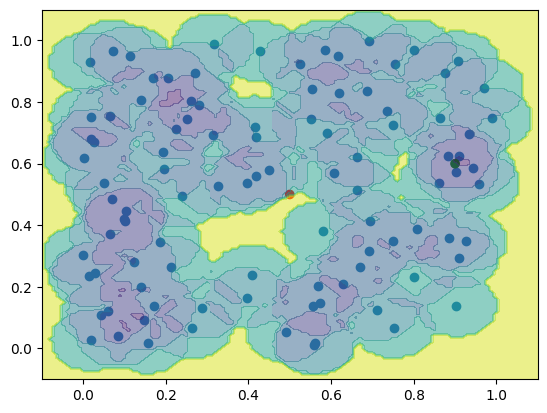

In [3]:
# ε近傍法
plt.scatter(x1[:,0], x1[:,1]);
plt.scatter(x2[:,0], x2[:,1], color=['red', 'green']);

plt.contourf(xx,yy,knn_anomaly(near_k, N, 0.1).reshape(121,121), alpha=.5)

#### ラベル付きデータに対するk近傍法
$M$次元空間で異常標本と正常標本の双方が明示的に与えらrている場合を考える。  
この場合、ラベル$y$が1か0かに応じた条件付き分布を求める必要がある。  
ある$\boldsymbol{x}'$に対する異常度を計算するには、あらかじめ与えられた近傍数$k$の数だけ近傍標本を選び、ラベルを確認する。  
異常ラベルの付いた近傍標本の数を$N^1(\boldsymbol{x}')$とし、正常ラベルの付いた近傍標本の数を$N^0(\boldsymbol{x}')$とすれば明らかに、 
$$
p(y=1|\boldsymbol{x}',D)=\frac{N^1(\boldsymbol{x}')}{k}\\
p(y=0|\boldsymbol{x}',D)=\frac{N^0(\boldsymbol{x}')}{k}
$$
が成り立つ。  
これにベイズの定理を適用して$\boldsymbol{x}'$と$y$の立場を入れ替えると、異常度は、
$$
a(\boldsymbol{x}')=\ln{\frac{p(\boldsymbol{x}'|y=1,D)}{p(\boldsymbol{x}'|y=0,D)}}=\ln{\frac{\pi^0N^1(\boldsymbol{x}')}{\pi^1N^0(\boldsymbol{x}')}}
$$
のように定義できる。  
ただし、$\pi^1$は全標本に対する異常標本の割合、$\pi^0$は全標本に対する異常標本の割合である。  
近傍法による異常検知のアルゴリズムを示す。  
>- 訓練時　探索する$k$と$a_{th}$の候補を挙げておく  
距離の定義を決める  
それぞれの$(k,a_{th})$について以下を行い、最大のF値を与えるパラメータ$(k^*,a^*_{th})$を選択する  
>1. $D$の中から標本$\boldsymbol{x}^{(n)}$を選ぶ$(n=1,\cdots,N)$
2. 残りの$N-1$個の標本の中から、$\boldsymbol{x}^{(n)}$に最も近い標本を$k$個選ぶ
3. $a(\boldsymbol{x}^{(n)})>a_{th}$なら$\boldsymbol{x}^{(n)}$を異常と判定する
4. $N$個の標本すべてに判定結果が出そろったら、正常標本精度と異常標本精度を計算し、F値を求める  
それを$(k,a_{th})$の評価値とする
>- 運用時
>1. 新たな観測値$\boldsymbol{x}'$に対して、最近傍$k^*$個を$D$から選ぶ
2. $a(\boldsymbol{x}'^{(n)})>a^*_{th}$なら$\boldsymbol{x}'$を異常と判定する

今回は、距離尺度としてユークリッド距離を使用する。

In [50]:
def near_k_id(x1, x2, A, k):
    """k近傍点のid
    """
    dist=((x1- x2.reshape(len(x2),1,2))@A).reshape(len(x2),len(x1),1,2)@(x1- x2.reshape(len(x2),1,2)).reshape(len(x2),len(x1),2,1)
    dist = dist[:,:,0,0]
    neark_ids = np.argsort(dist, axis=1)[:,1:k+1]
    return neark_ids

def calc_a(ath, ids, eps = 1e-3):
    """全標本に対する正常標本・異常標本の割合
    """
    pi0 = np.sum(y==0)/len(y)
    pi1 = np.sum(y==1)/len(y)
    
    N0 = np.sum(y[ids]==0, axis=1)
    N1 = np.sum(y[ids]==1, axis=1)
        
    # 異常度
    a = np.log((pi0*N1+eps)/(pi1*N0+eps))
    y_pred = (a>ath).astype(int)
    return y_pred

def calc_TPTF(A, k, ath):
    """正常標本精度や異常標本精度、F値などの計算
    """
    y_pred = np.zeros(len(x3))
    # 1対N-1でラベルの予測
    ids = near_k_id(x3, x3, A, k=k)
    y_pred = calc_a(ath, ids)
        
    # 正常標本精度と異常標本精とF値
    TP = np.sum((y_pred==1)*y) / np.sum(y==1)
    TF = np.sum((y_pred==0)*(1-y)) / np.sum(y==0)
    
    F = 2*TP*TF/(TP+TF)
    return TP, TF, F, y_pred

# ラベル付きデータの作成
x3 = np.concatenate([np.random.rand(100, 2),
                    np.random.rand(25, 2)/4+0.4])
y = np.array([0]*100+[1]*25)

# 最大のF値を与えるk,athの算出
K = np.arange(1, 10)
Ath = np.arange(-3, 3, 0.2)

F = np.zeros((len(K), len(Ath)))
for i, k in enumerate(K):
    for j, a in enumerate(Ath):
        F[i, j] = calc_TPTF(np.eye(2), k, a)[2]

max_id = np.where(F==np.max(F))
k_best = K[min(max_id[0])]
ath_best = Ath[max(max_id[1])]
print(k_best)
print(ath_best)

5
1.600000000000004


[0.3 0.6] :  0
[0.5 0.4] :  1


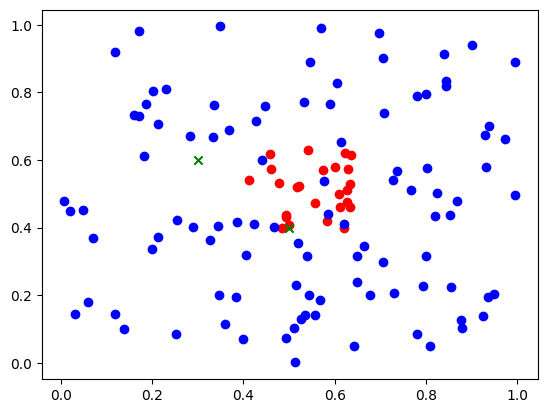

In [51]:
x4 = np.array([[0.3, 0.6],
               [0.5, 0.4]])

test_ids = near_k_id(x3, x4, np.eye(2), k=k_best)
y_pred = calc_a(ath=ath_best, ids=test_ids)
for i in range(len(x4)):
    print(x4[i,:], ": ", y_pred[i])

plt.scatter(x3[y==1,0], x3[y==1,1], color='red');
plt.scatter(x3[y==0,0], x3[y==0,1], color='blue');

plt.scatter(x4[:,0], x4[:,1], color='green', marker='x');

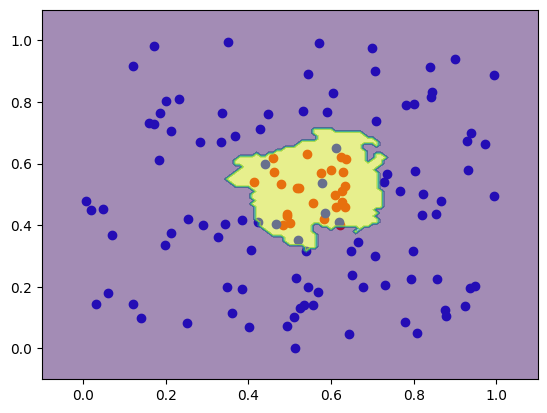

In [52]:
_x = np.arange(-0.1,1.1,0.01)
_y = np.arange(-0.1,1.1,0.01)
xx, yy = np.meshgrid(_x, _y)
XY = np.array([xx.ravel(), yy.ravel()]).T

test_ids = near_k_id(x3, XY, np.eye(2), k=k_best)
y_pred = calc_a(ath=ath_best, ids=test_ids)

plt.scatter(x3[y==1,0], x3[y==1,1], color='red');
plt.scatter(x3[y==0,0], x3[y==0,1], color='blue');

plt.contourf(xx,yy,y_pred.reshape(121,121), alpha=.5)

### 4.2 マージン最大化近傍法
#### 計量学習
異常か正常かのラベル付きデータ$D=\{(\boldsymbol{x}^{(n)}, y^{(n)}|n=1,\cdots,N)\}$があるとする。  
ユークリッド距離の代わりに、$M×M$半正定値行列$A$を使って、2つの標本間の距離の2乗を
$$
d^2_A(\boldsymbol{x}',\boldsymbol{x}'')=(\boldsymbol{x}'-\boldsymbol{x}'')^TA(\boldsymbol{x}'-\boldsymbol{x}'')
$$
のように置く。  
$A$をうまく決めれば、性能の向上が期待できる。  
行列$A$をデータから学習する手法を一般に**計量学習(またはリーマン計量)**と呼ぶ。  
Aが$M$次元単位行列$I_M$であればユークリッド距離の2乗と同じである。  
  
考えるべき点は
- 同一ラベルに属する標本をなるべく密集させること
- 異なるラベルに属する標本をできる限り引き離すこと

の2点である。  
  
#### マージン最大化近傍法の目的関数
この2つの条件を実装したものが、マージン最大化近傍法という計量学習の手法である。  

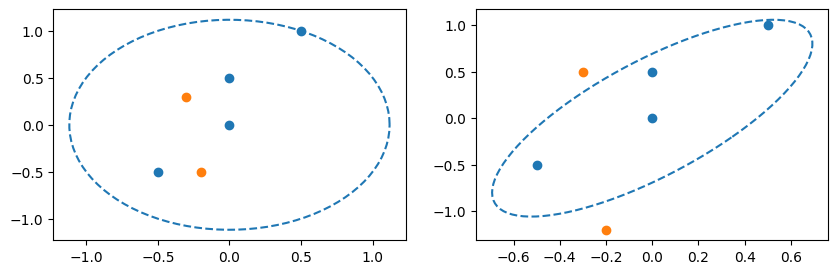

In [53]:
def make_ellipse(x, y, a, b, theta, phi):
    e = np.concatenate([[x + a * np.cos(theta)], [y + b * np.sin(theta)]], axis=0)
    return np.dot(np.matrix([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]]), e).T


p1 = np.array([[0, 0],
               [0,0.5],
               [0.5, 1],
               [-0.5, -0.5]])
p2 = np.array([[-0.3, 0.3],
               [-0.2, -0.5]])

c1 = make_circle(0, 0, r=np.sqrt(0.5**2+1), theta=theta)

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1))

axes[0].scatter(p1[:,0], p1[:,1]);
axes[0].scatter(p2[:,0], p2[:,1]);
axes[0].plot(c1[:,0], c1[:,1], '--');


c2 = make_ellipse(0, 0, 0.4, 1.2, theta=theta, phi=-np.pi/6)
p2 = np.array([[-0.3, 0.5],
               [-0.2, -1.2]])
axes[1].scatter(p1[:,0], p1[:,1]);
axes[1].scatter(p2[:,0], p2[:,1]);
axes[1].plot(c2[:,0], c2[:,1], '--');

近傍数$k$をパラメータとして与え、$A=I_M$としたときの距離の定義を用いて、$D$に属する任意の標本$\boldsymbol{x}^{(n)}$の、  
同一ラベルに属する$k$個の正近傍標本を求める。  
それを$N^{(n)}$と表し、**標的近傍**と呼ぶ。(図では$k=3$の場合を示している。)  
同一ラベルの標本をなるべく密集させるという条件は、
$$
\psi_1^{(n)}(A)=\sum_{i\in N^{(n)}}d^2_A(\boldsymbol{x}^{(n)},\boldsymbol{x}^{(i)})
$$
をなるべく小さくする、と表現できる。  
一方、異なるラベルの標本が良く分離している条件は、図を見ながら考えると、
$$
(\boldsymbol{x}^{(n)}から異なるラベルの標本までの2乗距離)>(\boldsymbol{x}^{(n)}から同一ラベルの標本までの2乗距離)+c^2
$$

と考えることができる。  
このとき、$c$は**マージン**と呼び、2乗距離が$A$に比例することから$c$は$A$のスケール因子に吸収させることが可能で、  
一般性を失わずに$c=1$とすることができる。  
全標本について満たすことは難しいが、「条件が破られている度合い」を
$$
\psi_2^{(n)}(A)=\sum_{j\in N^{(n)}}\sum_{l=1}^NI[y^{(l)}\neq y^{(n)}]\bigl[1+d^2_A(\boldsymbol{x}^{(n)},\boldsymbol{x}^{(j)})-d^2_A(\boldsymbol{x}^{(n)},\boldsymbol{x}^{(l)}) \bigr]_+
$$

$I[・]$は、$[]$内の式が成り立つときに1、そうでないときは0となる指示関数である。  
$[h]_+$は、$h\geq0$であれば$h$、$h<0$であれば0となる関数である。  
リーマン計量$A$を求めるための最適化問題は次のように書ける。
$$
\Psi(A)=\frac{1}{N}\sum_{n=1}^N\bigl[(1-\mu)\psi_1^{(n)}(A)+\mu\psi_2^{(n)}(A) \bigr]→最小化\\
subject\ to　A:半正定値行列
$$

#### 勾配法による最適化
マージン最大化近傍法の最適化問題は半正定値計画だるが、勾配法と固有値問題を組み合わせて解くことができる。  
$\Psi(A)$の最小化するための一般的な更新式は
$$
A←A-\eta\frac{\partial \Psi(A)}{\partial A}
$$

となる。$\eta$は勾配法のステップ幅である。  
$[・]_+$は微分できない関数であるので、微分可能な目的関数に対する勾配法との違いを強調して**劣勾配法**と呼ぶ。  
この場合、$[・]_+$の中に正の項しか入らないようにすれば、普通の勾配法と同様になる。  
  
今$N$次元空間における$i$方向の単位ベクトルを$\boldsymbol{e}_i$とかき、これを使って
$$
C^{(i,j)}=(\boldsymbol{e}_i-\boldsymbol{e}_j)(\boldsymbol{e}_i-\boldsymbol{e}_j)^T
$$
という行列を定義する。  
$$
\frac{\partial \Psi(A)}{\partial A}=\frac{1}{N}XCX^T\\
C=\sum_{n=1}^N\sum_{j\in N^{(n)}}\bigl\{(1-\mu)C^{(n,j)}+\mu\sum_{l\in N_{n,j}}(C^{(n,j)}-C^{(n,l)}) \bigr\}
$$

ただし、$X$はデータ行列で、$X=[\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(N)}]$のように定義される。  
また、集合は$N_{n,j}$は、$\boldsymbol{x}^{(n)}$および$\boldsymbol{x}^{(j)}$と異なるラベルを持ち、  
なおかつ$1+d_A^2(\boldsymbol{x}^{(n)},\boldsymbol{x}^{(j)})-d_A^2(\boldsymbol{x}^{(n)},\boldsymbol{x}^{(l)})>0$となる標本の添え字$l$の集合である。  
集合$N^{(n)}$は$A$の更新により変わることはないが、$N_{n,j}$は$A$の更新のつど変化することに注意する。  
$A$が更新されたら、固有値分解$A=U\Gamma U^T$を行い、
$$
A←U[\Gamma]_+ U^T
$$
のようにさらに$A$を更新する。  
ここで、$[\Gamma]_+$は負の固有値を0で置き換えることを意味する。  
アルゴリズムを示す。  
標本数の不均衡の是正は、**ブートストラップ法**により、  
少数クラスの見かけ上の標本数を増やすか、多数クラスの標本を間引くかすることでおこなうのが一般的である。  
>- 初期化:　近傍数$k$、係数$\mu$、ステップ幅の初期値$\eta_0$を与える  
$A=I_M$と置く。各クラスの標本数の不均衡がある場合は前処理で是正しておく。  
>- 反復:　次の更新式を実行する  
実行のたびに収束を判定し、収束していない場合、ステップ幅$\nu$を更新して繰り返す  
$$
A←A-\eta\frac{\partial \Psi(A)}{\partial A}\\
A=U\Gamma U^T\\
A←U[\Gamma]_+ U^T
$$
>- 収束した$A^*$を出力する

In [54]:
def make_Cij(N):
    """行列Cijを作成
    """
    c = np.matrix(np.eye(N))
    Cij = np.array([[(c[:,i]-c[:,j])@(c[:,i]-c[:,j]).T for j in np.arange(N)] for i in np.arange(N)])
    return Cij

def dA2(x1, x2, A):
    """距離の計算
    """
    return (x1-x2)@A@(x1-x2).T

def recalc_A(A, x, y, k, mu, eta):
    """Aを更新する
    """
    # 多数クラスを間引いて標本数を揃える
    min_count = min(np.bincount(y))
    x_bs = np.concatenate([x[y==label][np.random.choice(np.arange(np.sum(y==label)), min_count)] for label in np.unique(y)])
    y_bs = np.concatenate([[label]*min_count for label in np.unique(y)])
    N = len(x_bs)
    
    # 各標本同士の距離
    d = np.array([[dA2(x_bs[i],x_bs[j], A) for j in np.arange(N)] for i in np.arange(N)])
    Nn = near_k_id(x_bs, x_bs, np.eye(M), k=k)
    Cij = make_Cij(N)
    
    # 行列Cを計算
    C = np.matrix(np.zeros((N,N)))
    for n in np.arange(N):
        for j in Nn[n]:
            Nnj = np.where((d[n] < d[n][j]+1)&(d[n]!=0)&(y_bs!=y_bs[n]))[0]
            C += (1-mu)*Cij[n,j] + mu * np.sum((Cij[n,j]-Cij[n,Nnj]), axis=0)

    # 勾配を計算　
    dpsi = np.dot(np.dot(x_bs.T, C), x_bs)/N
    
    # 更新の実行
    A_new = A - dpsi
    U = np.linalg.eig(A_new)[1]
    G = np.linalg.eig(A_new)[0]
    G=np.diag(G)
    G[G<0]=0
    A_new = U@G@np.linalg.inv(U)
    return A_new

In [55]:
M = 2

k = 5
mu = 0.5
eta = 0.1

A = np.eye(M)
for i in np.arange(100):
    A_new = recalc_A(A, x3, y, k, mu, eta)
    # 収束するまで繰り返す
    if np.linalg.det(A-A_new) < 0.0001:
        A = A_new
        print(i,' break')
        break
    A = A_new
A=np.array(A)

2  break


array([[80.1111302 , -7.0081553 ],
       [-7.0081553 , 61.06183459]])

In [56]:
K = np.arange(1, 10)
Ath = np.arange(-10, 10, 0.5)

F = np.zeros((len(K), len(Ath)))
for i, k in enumerate(K):
    for j, a in enumerate(Ath):
        F[i, j] = calc_TPTF(A, k, a)[2]

max_id = np.where(F==np.max(F))
k_best = K[min(max_id[0])]
ath_best = Ath[max(max_id[1])]
print(k_best)
print(ath_best)

4
1.5


[0.3 0.6] :  0
[0.5 0.4] :  1
[0.55 0.5 ] :  1


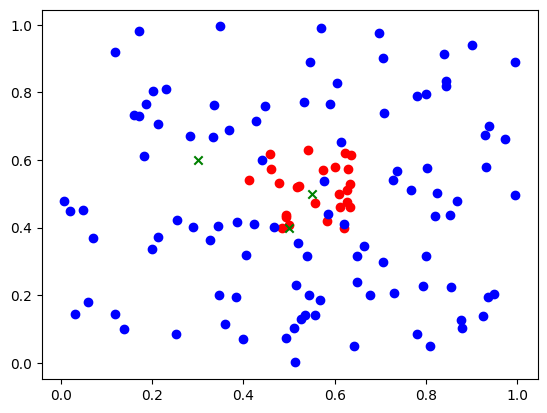

In [57]:
x4 = np.array([[0.3, 0.6],
               [0.5, 0.4],
               [0.55, 0.5]])

test_ids = near_k_id(x3, x4, A, k=k_best)
y_pred = calc_a(ath=ath_best, ids=test_ids)
for i in range(len(x4)):
    print(x4[i,:], ": ", y_pred[i])

plt.scatter(x3[y==1,0], x3[y==1,1], color='red');
plt.scatter(x3[y==0,0], x3[y==0,1], color='blue');

plt.scatter(x4[:,0], x4[:,1], color='green', marker='x');

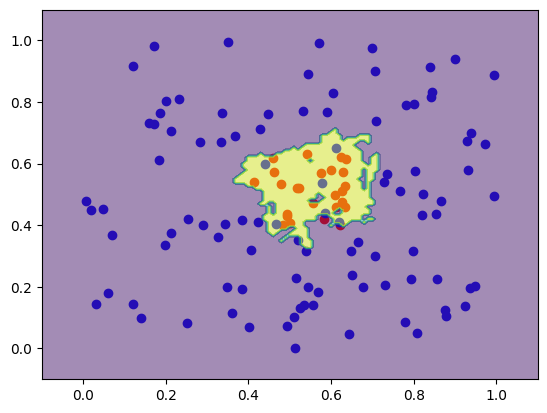

In [58]:
_x = np.arange(-0.1,1.1,0.01)
_y = np.arange(-0.1,1.1,0.01)
xx, yy = np.meshgrid(_x, _y)
XY = np.array([xx.ravel(), yy.ravel()]).T

test_ids = near_k_id(x3, XY, A, k=k_best)
y_pred = calc_a(ath=ath_best, ids=test_ids)

plt.scatter(x3[y==1,0], x3[y==1,1], color='red');
plt.scatter(x3[y==0,0], x3[y==0,1], color='blue');

plt.contourf(xx,yy,y_pred.reshape(121,121), alpha=.5)